In [123]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il

import itertools as it
import random
import warnings

from scipy import optimize


# needed?
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread

%load_ext ipydex.displaytools
%matplotlib inline

The ipydex.displaytools extension is already loaded. To reload it, use:
  %reload_ext ipydex.displaytools


In [124]:
import stage_2a_bar_selection as bs
il.reload(bs)

from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,

)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [125]:
img_fpath = "/home/ck/iee-ge/XAI-DIA/image_classification/stage2/single_bars/raw2/2023-06-26_06-18-47_C50.jpg"

# relevant for angle debugging: a24

In [126]:
def get_raw_cell(fpath, hr_row, hr_col, e=0, f=0):

    # hr_row, hr_col = "c", "8"

    img = load_img(fpath)
    bbox_list = get_bbox_list(img, plot=False)

    assign_row_col(bbox_list)
    handle_missing_boxes(bbox_list, fpath)

    assert len(bbox_list) == 81

    assert hr_row in ("a", "b", "c")
    row_idx = {"a": 0, "b": 1, "c": 2}[hr_row]
    col_idx = int(hr_col) - 1

    idcs = bbox_list[row_idx*27 + col_idx]
    x, y, w, h = idcs[:4]
    part_img = img[y-e:y+h+e, x-f:x+w+f, :]
    
    # convert to Lightness A, B and then split to get lightness
    L, _, _ = cv2.split(cv2.cvtColor(part_img, cv2.COLOR_BGR2LAB)   )

    # plt.imshow(rgb(part_img))
    plt.imshow(L)
    
    return L


In [127]:
class Attr_Array(np.ndarray):
    """
    Special layer on top of numpy arrays which accept custom attributes
    """
    def __new__(cls, input_array, **kwargs):
        obj = np.asarray(input_array).view(cls)
        for k, v in kwargs.items():
            setattr(obj, k, v)
        return obj

def rotate_img(img, angle, border_value=255):
    height, width = img.shape[:2]

    # Calculate the rotation matrix
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height), borderValue=border_value)
    return rotated_image

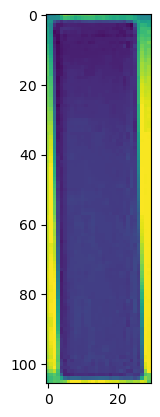

In [128]:
part_img_L = get_raw_cell(img_fpath, "a", "24", 2, 2)

Randspalten → Anstieg der Kurven korrelliert mit Verdrehung des Stäbchens

In [129]:
roi_part_img_L = part_img_L[5:-5, :] ##:i
rows, cols = roi_part_img_L.shape

# relevant column indices
jj = [0, 1, 2, 3]


# row indices
ii = np.array(np.arange(rows), dtype=float)

def piecewise_linear2(x, x0, y0, k1, k2):
    # model of two linear functions meeting in x0, y0
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

def piecewise_linear3(x, x0, y0, x1, k1, k2, k3):
    # model of two linear functions meeting in x0, y0
    return np.piecewise(
        x,
        [x < x0, np.logical_and(x0 < x, x < x1), x1 <= x],
        [
            lambda x: k1*x + y0 - k1*x0,
            lambda x: k2*x + y0 - k2*x0,
            lambda x: k3*x + (k2*x1 + y0 -k2*x0) - k3*x1,
        ]
    )


class Fitter:
    def __init__(self, ii):
        self.ii = ii
        
        # reservoir for initial guesses
        # x0, y0, x1, k1, k2, k3
        
        res3 = [
            [20, 35, 50],
            [100, 250],
            [60, 75, 90],
            [-3, 0, 3],
            [-3, 0, 3],
            [-3, 0, 3],
        ]
        
        random.seed(1946)
        self.res3_p0 = list(it.product(*res3))
        random.shuffle(self.res3_p0)

    def fit_sequence2(self, seq, p0=None):
        if p0 is None:
            p0 = (40, 250, 2.5, 0)
        p , e = optimize.curve_fit(piecewise_linear2, self.ii, seq, p0=p0)
        # print(f"{e=}")
        return p


    def fit_sequence3(self, seq, p0=None):
        if p0 is None:
            p0 = (40, 250, 80, 2.5, 0, 0)
        p, err = optimize.curve_fit(piecewise_linear3, self.ii, seq, p0=p0)
        
        # err is full cov matrix
        perr = np.sqrt(np.diag(err))
        p = Attr_Array(p, err=err, perr=perr)
        
        # print(f"{e=}")
        return p
    
    
    def smart_fit_sequence3(self, seq):
        
        best_params = None
        best_errors = [np.inf, np.inf, np.inf]
        N = len(best_errors)
        bad_counter = 0
        
        for p0_guess in self.res3_p0:
            with warnings.catch_warnings():
                # see also
                # https://stackoverflow.com/questions/31301017/catch-optimizewarning-as-an-exception
                # warnings.simplefilter("error", optimize.OptimizeWarning)
                warnings.simplefilter("ignore", optimize.OptimizeWarning)
                
                try:
                    p = self.fit_sequence3(seq, p0=p0_guess)
                except optimize.OptimizeWarning:
                    # note: due to the ignore-policy this get not triggered anymore
                    
                    # why this warning is triggered is unclear
                    # we use the result anyway
                    
                    # try again with other initial values
                    # print("warning raised")
                    # continue
                    pass
                    
            total_err = self.pw_err(piecewise_linear3, p, seq)[2]
            
            idx = np.searchsorted(best_errors, total_err)
            if idx >= N:
                bad_counter += 1
                if bad_counter >= 3:
                    # could not find better value
                    break
                
                # this initial guess was bad but we have some tries left
                continue
            
            # the result is quite good -> we have not yet explored sufficiently yet
            bad_counter = 0
            
            # print(idx, total_err)
            best_errors.insert(idx, total_err)
            worst = best_errors.pop()  # drop the worst value
            if worst == best_errors[0]:
                # we probably wont get better
                break
                        
            if idx == 0:
                best_params = p
               
        return best_params
            
        
    def pw_err(self, model, params, seq):
        
        L = len(params)
        assert L % 2 == 0
        
        # extract x0, x1, etc assuming that y0 has index 1
        borders = list(params[:L // 2])
        borders.pop(1)
        
        # the last (right) boder is infinity (because we use `<`)
        borders.append(np.inf)
        
        # now compile a list of index-arrays which corresspond to the borders
        all_idcs = np.arange(self.ii.shape[0])
        L_all_idcs = self.ii.shape[0]
        
        idcs_list = []
        tmp_ii = self.ii*1 # working copy of independent array
        for b in borders:
            mask = tmp_ii < b
            idcs = all_idcs[mask]
            idcs_list.append(idcs)
            
            # remaining indices and values
            all_idcs = all_idcs[np.logical_not(mask)]
            tmp_ii = tmp_ii[np.logical_not(mask)]
        
        model_seq = model(self.ii, *params)
        diff = np.abs(model_seq - seq)
        
        section_diffs = []
        fractions = []
        
        for idcs in idcs_list:
            
            # for every section calculate the mean difference and its share of the total length
            if len(idcs) == 0:
                section_diffs.append(0)
            else:
                section_diffs.append(np.mean(diff[idcs]))
            fractions.append(len(idcs)/L_all_idcs)
          
        # only for debug printing
        # idcs_list2 = [idcs[[0, -1]] for idcs in idcs_list]
        # print(borders, idcs_list2)
        
        total_diff = np.mean(diff)
        
        return fractions, section_diffs, total_diff
            
        
            
fitter = Fitter(ii=ii*1)

j = 1
p = fitter.fit_sequence3(roi_part_img_L[:, j])

fitter.pw_err(piecewise_linear3, p, roi_part_img_L[:, j])

info(roi_part_img_L) := "<class 'numpy.ndarray'> with shape: (96, 30)"

---

([0.4270833333333333, 0.40625, 0.16666666666666666],
 [2.4390437462583434, 1.8627613765664601, 3.249041993815645],
 2.3399287414972325)

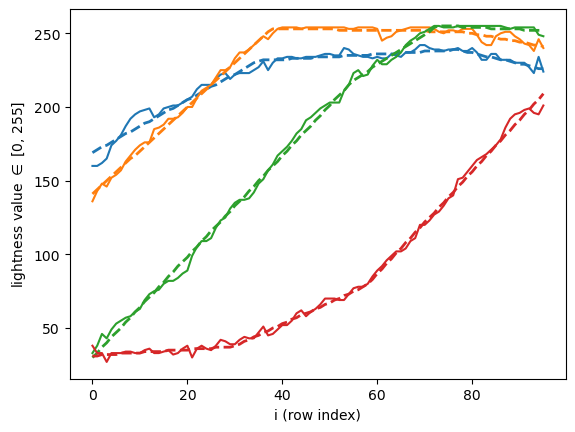

In [130]:
lines = plt.plot(roi_part_img_L[:, jj], alpha=0)
plt.xlabel("i (row index)")
plt.ylabel(r"lightness value $\in$ [0, 255]")
        
        

def process_column(img, j, plot=False):
    fitter = Fitter(ii=np.arange(img.shape[0]))
    # p = fitter.fit_sequence3(img[:, j])
    p = fitter.smart_fit_sequence3(img[:, j])
    p.errors = fitter.pw_err(piecewise_linear3, p, img[:, j])
    if plot:
        color = colors[j]
        plt.plot(img[:, j], color=color)
        plt.plot(fitter.ii, piecewise_linear3(fitter.ii, *p), "--", lw=2, color=color)
        
    return p


params = []
for j in jj:
    p = process_column(roi_part_img_L, j, plot=True)
    params.append(p)

In [12]:
qq = Attr_Array(ii, err=0) ##:

qq.err

qq := Attr_Array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
            12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
            24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
            36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.,
            48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.,
            60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.,
            72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
            84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.])

---

0

Kallibrierung

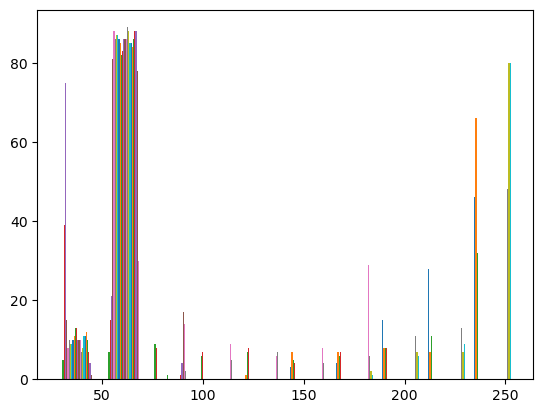

In [13]:
_ = plt.hist(roi_part_img_L)

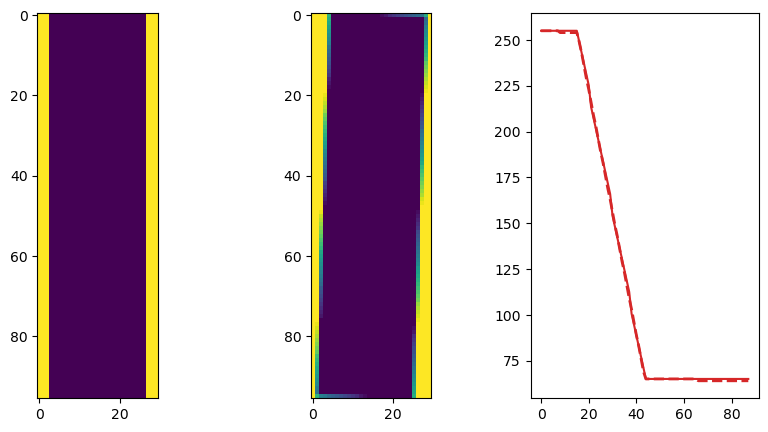

In [14]:
# test rect
test_img = np.ones(roi_part_img_L.shape)*255
e = 3
test_img[: , e:-e] = 65

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5));
ax1.imshow(test_img)

test_img2 = rotate_img(test_img, -2)
ax2.imshow(test_img2)

plt.sca(ax3)

params = []
for j in [3]:
    p = process_column(test_img2[4:-4], j, plot=True)
    params.append(p)


In [15]:
%%time


pp = []
angles = np.linspace(-3, 3, 20)

for angle in angles:
    
    test_img2 = rotate_img(test_img, angle)
    p = process_column(test_img2[4:-4], j)
    
    pp.append(p)
    
pp = np.array(pp)    

CPU times: user 1.78 s, sys: 3.97 ms, total: 1.79 s
Wall time: 1.79 s


Text(0, 0.5, 'slope')

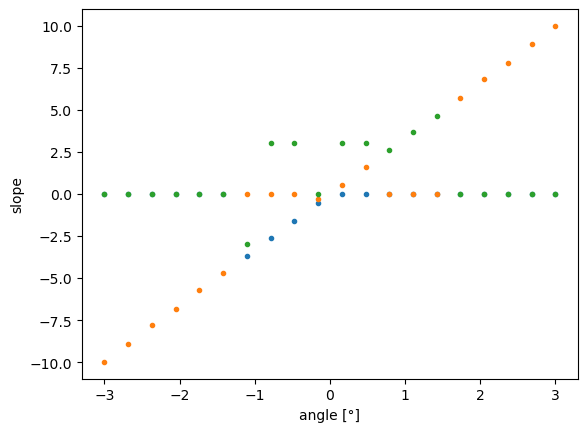

In [16]:
plt.plot(angles, pp[:, 3:], ".")
plt.xlabel("angle [°]")
plt.ylabel("slope")

Conclusion: we have a linear dependence between rotation angle and identified slope.

problem: for small angles it is still unclear which slope is relevant -> relevance score


scores for:

- being in the middle (+ 1)
- length of the section * 3
- absolute slope value / 5 (we expect values between -10 and 10)
- minus the difference from the max-abs value

In [17]:
# redefine this function now with scoring
def process_column(img, j, plot=False):
    fitter = Fitter(ii=np.arange(img.shape[0]))
    # p = fitter.fit_sequence3(img[:, j])
    p = fitter.smart_fit_sequence3(img[:, j])
    p.errors = fitter.pw_err(piecewise_linear3, p, img[:, j])
    if plot:
        color = colors[j]
        plt.plot(img[:, j], color=color)
        plt.plot(fitter.ii, piecewise_linear3(fitter.ii, *p), "--", lw=2, color=color)
        
    p.scored_slopes = []  # will contain tuples
    fractions = p.errors[0]
    # assume pw3 model
    max_abs_slope = np.max(np.abs(p[3:]))
    for i, slope in enumerate(p[3:]):
        
        # score heuristic
        p.scored_slopes.append((
            slope,
            int(i == 1) + fractions[i]*3 + np.abs(slope)/5 + np.abs(slope) - max_abs_slope
        ))
    
    p.scored_slopes.sort(key = lambda tup: tup[1])
    p.estimated_slope = p.scored_slopes[-1][0]
    
    return p


def get_angle(img):
    
    column_indices = [1, 2, -2, -1]
    angles = []
    for j in column_indices:
        a = process_column(img, j).estimated_slope / 3.31 * np.sign(j)
        angles.append(a)
        
    angles.sort()
        
    # drop extreme values
    return np.mean(angles[1:-1])
    
    

(p[[0, 2]]) := Attr_Array([44.90226882, 90.        ])

---

(p[3:]) := Attr_Array([8.70367324e-10, 1.02754077e+00, 3.00000000e+00])

---

[(8.703673240345755e-10, Attr_Array(-1.46590909)),
 (3.0, Attr_Array(0.6)),
 (1.027540774892415, Attr_Array(0.69895802))]

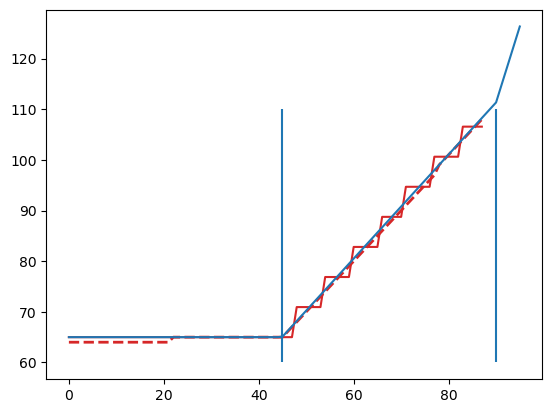

In [18]:
test_img2 = rotate_img(test_img, 0.3)
p = process_column(test_img2[4:-4], 3, plot=True)
plt.vlines(p[[0, 2]], 60, 110)

qq = piecewise_linear3(ii, *p)
plt.plot(ii, qq)
p[[0, 2]] ##:
p[3:] ##:
p.scored_slopes

slope_slope := 3.2881690408911037

---

CPU times: user 1.94 s, sys: 3.33 ms, total: 1.95 s
Wall time: 2 s


Text(0, 0.5, 'slope')

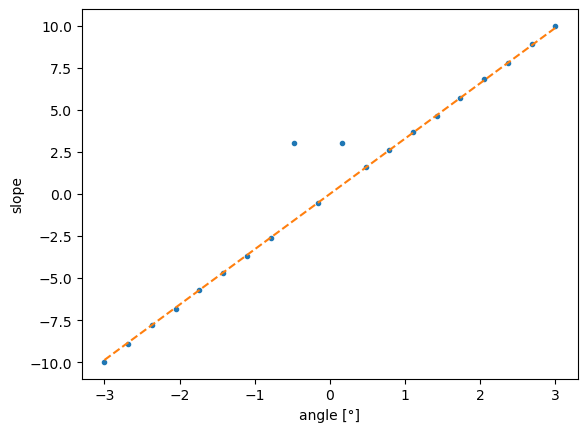

In [19]:
%%time

pp = []
angles = np.linspace(-3, 3, 20)

test_img1 = test_img*1

test_img1[test_img1==65] == 200

for angle in angles:
   
    test_img2 = rotate_img(test_img1, angle)
    p = process_column(test_img2[4:-4], j)
    
    pp.append(p.estimated_slope)
    
pp = np.array(pp)  

# linear regression (without offset):
slope_slope = np.linalg.lstsq(np.c_[angles], pp, rcond=None)[0][0] ##:

plt.plot(angles, pp, ".")

plt.plot(angles, angles*slope_slope, "--")
plt.xlabel("angle [°]")
plt.ylabel("slope")



Conclusion: detected slope and angle correlated with factor 3.31

slope_slope := -3.3236072235612304

---

CPU times: user 1.92 s, sys: 10.4 ms, total: 1.93 s
Wall time: 1.92 s


Text(0, 0.5, 'slope')

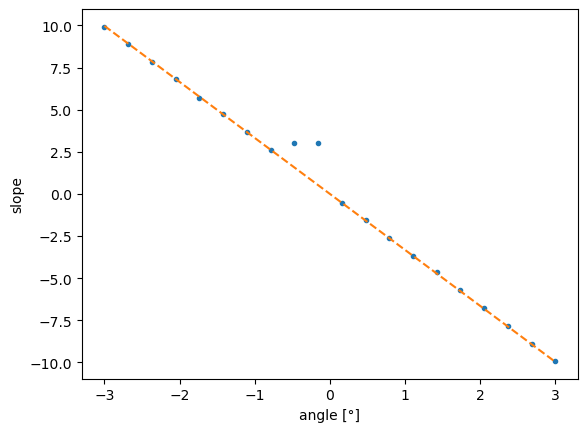

In [20]:
%%time

pp = []
angles = np.linspace(-3, 3, 20)

test_img1 = test_img*1

test_img1[test_img1==65] == 200

for angle in angles:
   
    test_img2 = rotate_img(test_img1, angle)
    p = process_column(test_img2[4:-4], -3)
    
    pp.append(p.estimated_slope)
    
pp = np.array(pp)  

# linear regression (without offset):
slope_slope = np.linalg.lstsq(np.c_[angles], pp, rcond=None)[0][0] ##:

plt.plot(angles, pp, ".")

plt.plot(angles, angles*slope_slope, "--")
plt.xlabel("angle [°]")
plt.ylabel("slope")


back to chocolate bars

In [43]:
%%time
a = get_angle(roi_part_img_L)
print(a)

[-0.9284601338159102, -0.9015678914748504, 0.9038650797755405, 1.0348630892527422]
0.0011485941503450725
CPU times: user 357 ms, sys: 3.68 ms, total: 361 ms
Wall time: 358 ms


In [45]:
type(a)

numpy.float64

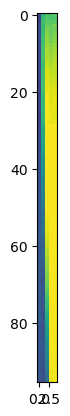

In [50]:
test_img3 = rotate_img(roi_part_img_L, float(-a))
plt.imshow(test_img3[:, -5:], vmin=0, vmax=255)

We can be content with this

-0.9284601338159102
-0.9015678914748504
1.2631334320928482
0.7735507435825391
-0.18073142131688869


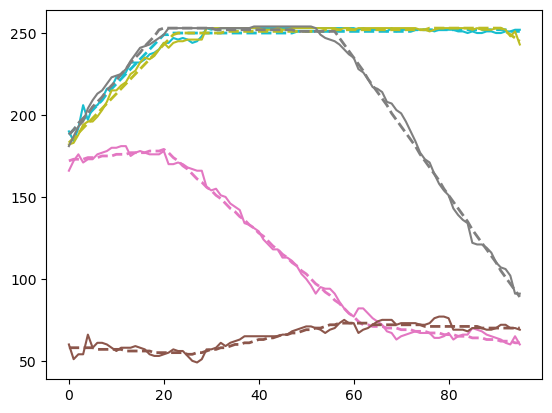

In [40]:

for j in [-1, -2, -3, -4, -5]:
    a = process_column(roi_part_img_L, j, plot=True)
    print(a.estimated_slope / 3.31 * np.sign(j))

Investigations to identify border columns (columns of pixels, which are completely considered part of the bar)

[2, 3, -3, -4]

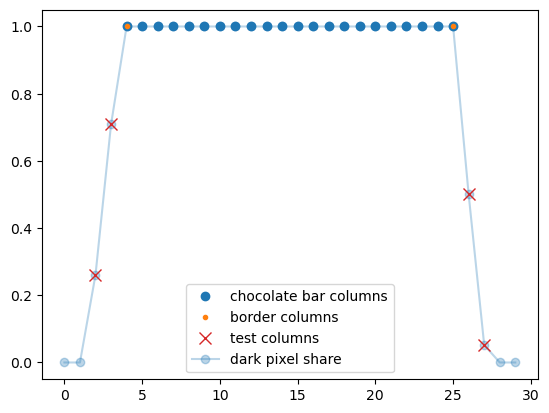

In [111]:
BAR_TRESHOLD = 110

def get_test_column_idcs(img, plot=False):
    
    n_rows, n_cols = img.shape
    dark_pixel_share = np.sum(img < BAR_TRESHOLD, axis=0)/n_rows

    jj = np.arange(n_cols)



    dark_pixel_indices = jj[dark_pixel_share > .8]

    j_first, j_last = dark_pixel_indices[[0, -1]]

    # actual test indices:
    j_left1 = np.max([j_first - 2, 0])
    j_left2 = j_left1 + 1

    # on the right side: calculate the corresponding negativ indices
    # i.e. right most col has index -1
    j_right1 = np.min([j_last + 2, n_cols - 1]) - n_cols
    j_right2 = j_right1 -1


    if plot:

        plt.plot(jj[dark_pixel_indices], dark_pixel_share[dark_pixel_indices], "o", label="chocolate bar columns")
        plt.plot(jj[[j_first, j_last]], dark_pixel_share[[j_first, j_last]], "o", ms=3, label="border columns")
        plt.plot(
            jj[[j_left1, j_left2, j_right1, j_right2]],
            dark_pixel_share[[j_left1, j_left2, j_right1, j_right2]],
            "x", color="tab:red", ms=8, label="test columns"
        )

        plt.plot(jj, dark_pixel_share, "o-", label="dark pixel share", color="tab:blue", alpha=0.3, zorder=0)

        plt.legend()


    return [j_left1, j_left2, j_right1, j_right2]
    
    
get_test_column_idcs(roi_part_img_L, plot=True)

In [112]:




def get_angle(img, dc=None):

    # column_indices = [1, 2, -2, -1]
    column_indices = get_test_column_idcs(img)
    angles = []
    for j in column_indices:
        res = process_column(img, j)
        a = res.estimated_slope / 3.31 * np.sign(j)
        angles.append(a)

        # collect debug data
        if dc is not None:
            if not hasattr(dc, "angle_res"):
                dc.angle_res = []

            dc.angle_res.append(res)
            dc.get_angle_image = img

    angles.sort()
    # drop extreme values
    
    angles2 = angles[1:-1]
    
    # print(angles, np.var(angles2))
    if np.var(angles2) > 0.4:
        msg = f"could not determine consistent angles: {angles2}"
        raise ValueError(msg)
    
    return np.mean(angles2)

Weiteres Problem identifizieren

In [119]:
fname = "2023-06-26_06-19-14_C50.jpg"; hr_row='b'; hr_col='2'

img_fpath = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0/2023-06-26_06-19-14_C50.jpg"

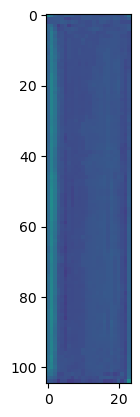

In [121]:
img = get_raw_cell(img_fpath, hr_row, hr_col)
plt.imshow(img, vmin=0, vmax=255)

In [122]:
get_angle(img)

[-3.323262834821464, -0.0, 0.0313417089021509, 6.042296107076205] 0.00024557567922679123


0.01567085445107545

In [66]:
np.var([-0.9015678914748504, 0.9038650797755405])

0.8148970534195037

l1 := 594

---

l2 := 2277

---

(l1 + l2 - len(tt)) := 0

---

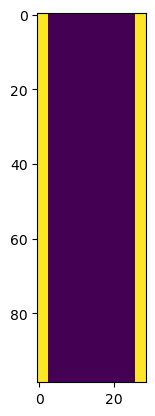

In [274]:
tt = test_img.flatten()*1


l1 = len(tt[tt==255]) ##:
l2 = len(tt[tt==65]) ##:
l1 + l2 - len(tt) ##:


plt.imshow(test_img)
# _ = plt.hist(test_img)

In [129]:
params[0][-3:] ##:

params[0].errors

(params[0][-3:]) := Attr_Array([-5.05500428e+00, -1.52565328e+00,  1.36906873e-08])

---

([0.45054945054945056, 0.21978021978021978, 0.32967032967032966],
 [18.538109756097562, 15.78125, 4.0],
 13.139423076923077)

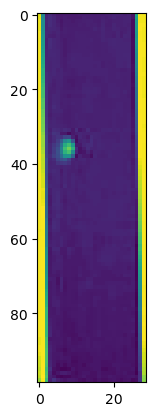

In [52]:
plt.imshow(roi_part_img_L)

In [13]:
params

[array([ 5.29336404e+00,  2.52859083e+02,  8.93647492e+01,  1.14285723e+00,
        -5.12302643e-03, -2.63333340e+00]),
 array([3.99999940e+01, 2.35742200e+02, 5.30209217e+01, 2.25418317e+00,
        1.36016590e+00, 2.52861178e-03]),
 array([39.06775768, 92.71438914, 82.97402424,  0.69831145,  2.20794322,
         0.46911754]),
 array([41.2377749 , 70.33056119, 68.39585899, -0.09083542, -0.23931626,
         0.29365963])]

In [111]:
np.logical_and((ii < 40), (ii > 20))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [104]:
plt.plot(ii, piecewise_linear3(ii, 40, 250, 80, 2.5, 0, -2))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
%time

optimize.curve_fit(piecewise_linear2, ii, qq, p0=(40, 250, 2.5, 0))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


(array([4.79978500e+01, 2.51874708e+02, 2.19745984e+00, 4.81447898e-02]),
 array([[ 9.26757617e-02,  9.80359622e-02, -3.26660039e-03,
         -2.77931275e-03],
        [ 9.80359622e-02,  2.10345261e-01, -1.57269809e-04,
         -6.10742809e-03],
        [-3.26660039e-03, -1.57269809e-04,  2.86594680e-04,
          7.11681130e-13],
        [-2.77931275e-03, -6.10742809e-03,  7.11681130e-13,
          2.38924106e-04]]))

In [92]:
j = 1
roi_part_img_L[:, j]
qq = np.array(roi_part_img_L[:, j], dtype=float) ##:
p = fit_sequence(qq)

qq := 
array([145., 147., 150., 151., 153., 156., 158., 162., 164., 166., 168.,
       171., 173., 175., 177., 182., 182., 184., 185., 189., 192., 194.,
       195., 200., 201., 201., 205., 207., 209., 211., 212., 214., 218.,
       222., 223., 223., 225., 229., 234., 233., 234., 235., 237., 240.,
       242., 242., 242., 248., 247., 247., 248., 250., 254., 254., 254.,
       253., 253., 253., 252., 252., 253., 253., 253., 254., 254., 254.,
       254., 254., 254., 253., 254., 254., 253., 253., 254., 254., 254.,
       254., 254., 254., 254., 254., 254., 254., 254., 254., 254., 253.,
       253., 253., 253., 253., 252., 253., 254., 254., 253., 255., 252.])

---

e=array([[ 9.26757617e-02,  9.80359622e-02, -3.26660039e-03,
        -2.77931275e-03],
       [ 9.80359622e-02,  2.10345261e-01, -1.57269809e-04,
        -6.10742809e-03],
       [-3.26660039e-03, -1.57269809e-04,  2.86594680e-04,
         7.11681130e-13],
       [-2.77931275e-03, -6.10742809e-03,  7.11681130e-13,
         2.38924106e-04]])


e=array([[ 1.58148726e-01, -3.29155608e-02, -5.72858440e-04,
        -6.20733645e-02],
       [-3.29155608e-02,  8.99421085e-02,  1.50852720e-03,
        -5.28328132e-04],
       [-5.72858440e-04,  1.50852720e-03,  3.38461832e-05,
        -2.13258137e-15],
       [-6.20733645e-02, -5.28328132e-04, -2.13258137e-15,
         3.42650478e-02]])
e=array([[ 9.26757617e-02,  9.80359622e-02, -3.26660039e-03,
        -2.77931275e-03],
       [ 9.80359622e-02,  2.10345261e-01, -1.57269809e-04,
        -6.10742809e-03],
       [-3.26660039e-03, -1.57269809e-04,  2.86594680e-04,
         7.11681130e-13],
       [-2.77931275e-03, -6.10742809e-03,  7.11681130e-13,
         2.38924106e-04]])
e=array([[ 2.15100133e+00,  3.05251390e+00,  1.00340323e-01,
         2.18171487e-02],
       [ 3.05251390e+00,  5.27711421e+00,  1.88860583e-01,
         1.02575780e-02],
       [ 1.00340323e-01,  1.88860583e-01,  9.43645890e-03,
        -1.40702230e-11],
       [ 2.18171487e-02,  1.02575780e-02, -1.40702230e-11

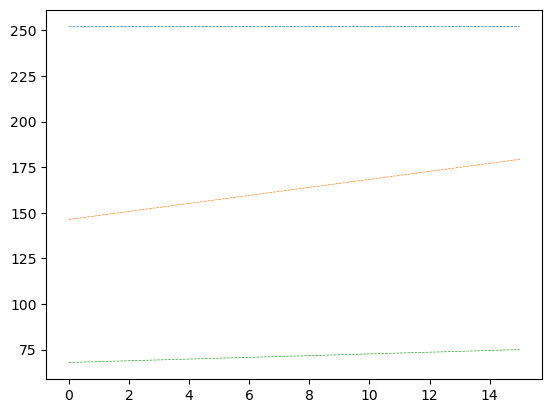

In [93]:
params = []
for j, line in zip(jj, lines):
    p = fit_sequence(roi_part_img_L[:, j])
    params.append(p)
    color = line.get_color()
    plt.plot(xd, piecewise_linear(xd, *p), "--", lw=0.5, color=color)

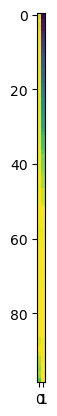

In [59]:
plt.imshow(roi_part_img_L[:, :2])

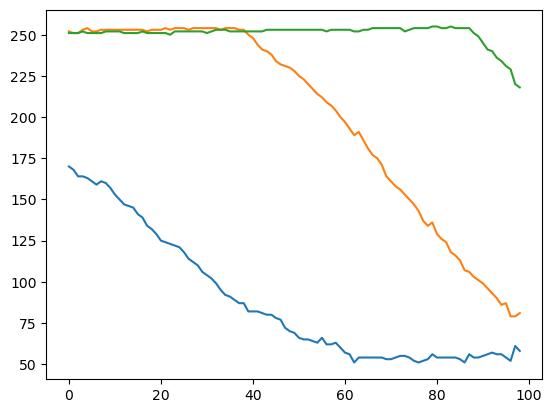

In [52]:
_ = plt.plot(part_img_L[5:-5, [-3, -2, -1,]])

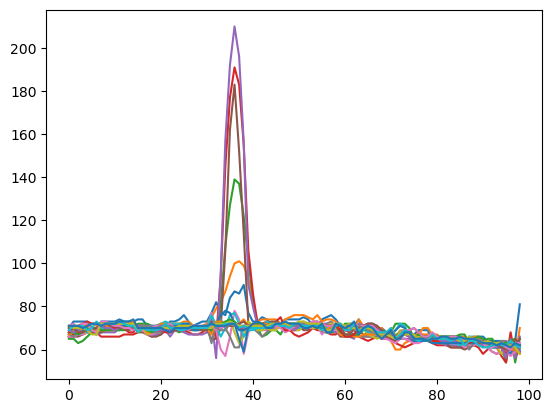

In [50]:
_ = plt.plot(part_img_L[5:-5, 4:-4])

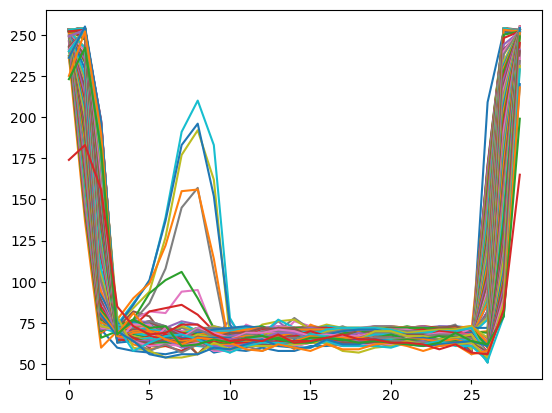

In [45]:
plt.plot(part_img_L[2:-3,:].T)
pass

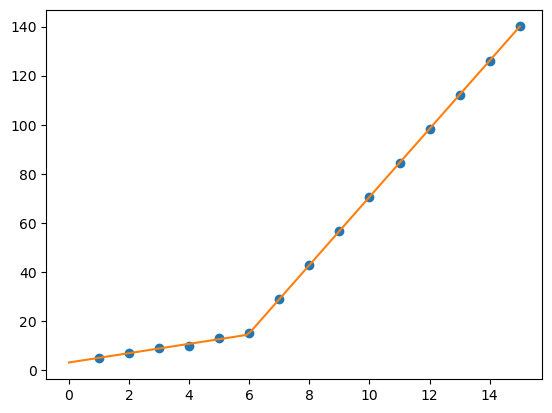

In [54]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 10, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x, y)
xd = np.linspace(0, 15, 100)
plt.plot(x, y, "o")
plt.plot(xd, piecewise_linear(xd, *p))

In [55]:
optimize.curve_fit?

In [12]:

def adapt_rotation_and_margin(bbox, img, forced_angle=None, plot=True):

    x, y, w, h = bbox[:4]

    d = 5 # margin added before rotation
    e = d - 2 # margin subtracted after rotation
    part_img = img[y-d:y+h+d, x-d:x + w+d, :]

    gray = cv2.cvtColor(part_img, cv2.COLOR_BGR2GRAY)

    # generated by perplexity ai

    # Apply Canny edge detection to the grayscale image
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    tested_angles = np.deg2rad(np.arange(-5.0, 5.0, step=0.1 ))
    h, theta, d = hough_line(edges, theta=tested_angles)

    # Retrieve the lines detected by Hough transform
    _, angles, _ = hough_line_peaks(h, theta, d)
    angle = np.rad2deg(np.mean(angles))

    if 0:

        # Find contours in the edge image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if plot:
            # plt.imshow(edges)
            pass


        # Find the rectangle with the largest area
        max_area = 0
        max_rect = None
        max_cnt = None
        for cnt in contours:
            # this determines center, width, height and the angle
            rect = cv2.minAreaRect(cnt)
            area = rect[1][0] * rect[1][1]
            if area > max_area:
                max_area = area
                max_cnt = cnt
                max_rect = rect

        # Get the rotation angle of the rectangle
        angle = max_rect[2]

        if plot:
            cv2.drawContours(part_img, [max_cnt], 0, (0, 255, 0), 1)

            # now also draw the max_rect (which in general is rotated)
            box = cv2.boxPoints(max_rect)
            box = np.int0(box)

            # Draw the rotated rectangle on the original image
            cv2.drawContours(part_img, [box], 0, (200, 0, 0), 2)

            (xm, ym), (w, h), _ =  max_rect
            plt.imshow(part_img)
            plt.show()

    height, width = part_img.shape[:2]

    # adapt the rotation angle

    print(angle)

    if forced_angle is not None:
        angle = forced_angle
    else:
        if abs(angle) > 45:
            angle = angle - 90
        assert -5 <= angle <= 5

    # angle *= -1

    # Calculate the rotation matrix
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(part_img, rotation_matrix, (width, height))

    return rotated_image[e:-e, e:-e, :]

-0.6000000000000156


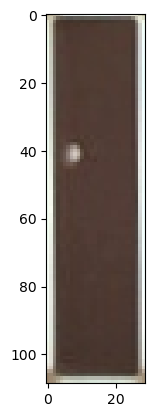

In [16]:

part_img = select_bar_from_file(img_fpath, "c", "8")
plt.imshow(rgb(part_img))